# ARIMA 

## Overview
**ARIMA** (AutoRegressive Integrated Moving Average) is a statistical model used for time series forecasting. It combines three components:

  1. **AR (Auto Regressive)** - correlation to past values
  2. **I (Integrated)** - differencing to make time series stationary 
  3. **MA (Moving Average)** - past errors  

It is a statistical model used to forecast future values based on the influence of the past values on the present values.  

# Packages to install
conda install conda-forge::scikit-learn  
conda install -c conda-forge pmdarima

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    mean_absolute_percentage_error)
from sklearn.model_selection import ParameterGrid

# Load and check stationarity 

ARIMA requires the time series to be **stationary** (constant mean and variance over time).  

We use the the **Augmented Dickey_Full (ADF)** test check if the timeseries is stationary.  
- The H0 (null hypothesis): the time series is NOT stationary.   
- The H1 (alternative hypthesis): the time series is stationary  
- If **p-value <= 0.05**, reject H0 and treat the time sereies as stationary

In [ ]:
#import the dataset and set the index to time 
df = pd.read_csv("AUS monthly beer production.csv", index_col=0, parse_dates=True)
df

,value
time,
1956-01-01,284.000000
1956-02-01,253.444206
1956-03-01,230.185302
1956-04-01,213.000000
1956-05-01,205.676860
...,...
2009-12-01,469.744786
2010-01-01,414.000000
2010-02-01,331.991312


<Figure size 1200x500 with 0 Axes>

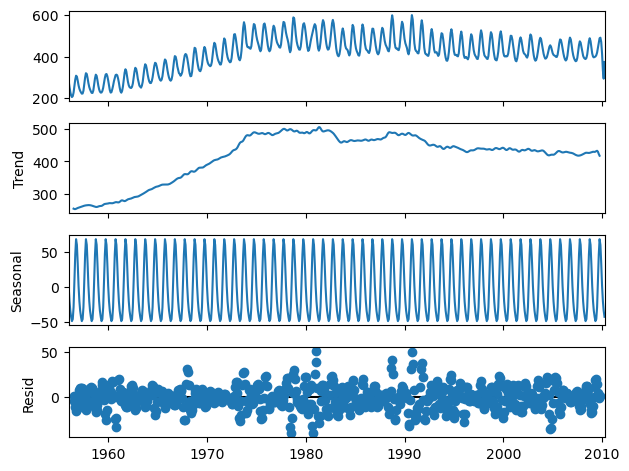

In [3]:
# plot the data to check if the time series is stationary

plt.figure(figsize=(12, 5))

decompose = seasonal_decompose(
    df, 
    model="additive", 
    period =12
)

decompose.plot()
plt.show()

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.

In [4]:
# check stationarity with ADF test

def check_stationarity(df): 
  result = adfuller(df)
  if result[1] > 0.05:
    print("The time series is not stationary")
  else:
    print("The time series is stationary")

check_stationarity(df)

The time series is not stationary


# ARIMA model

In statsmodels. ARIMA is denoted as (p, d, q), where:
- **p** = number of lags or autoregressive terms. It refers to the number of past observations that directly infleunce the current value.   
The  number is identified by **PACF**  

- **d** = number of differentiating. It represents the number of differences need to make the time series stationsry. Usually: 0 ≤ d ≤ 2  
  
- **q** = order of moving average values. It represents the number of lagged forecast errors.  
   

Package that automatically discover the optinmal number of ARIMA's parameters: [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)

**Key assumptions**:
1. The time series can be made stationary through differencing
2. Past values and past errors contain information useful for forecasting
3. The relationship between past and present is linear

## Train/Test Split

We split the data into 70% training and 30% testing sets.

```python
# df.iloc[:int(len(df)*0.7)] -> takes rows from index 0 to 70% of the data (training set)
# df.iloc[int(len(df)*0.7):] -> takes rows from 70% to the end (testing set)
```

In [5]:
# split the dataset in training and testing

train, test = df.iloc[:int(len(df)*0.7)], df.iloc[int(len(df)*0.7):]
train, test

(                 value
 time                  
 1956-01-01  284.000000
 1956-02-01  253.444206
 1956-03-01  230.185302
 1956-04-01  213.000000
 1956-05-01  205.676860
 ...                ...
 1993-08-01  443.237318
 1993-09-01  485.105528
 1993-10-01  512.000000
 1993-11-01  508.769037
 1993-12-01  483.625271
 
 [456 rows x 1 columns],
                  value
 time                  
 1994-01-01  449.000000
 1994-02-01  417.337447
 1994-03-01  395.598884
 1994-04-01  381.000000
 1994-05-01  379.650897
 ...                ...
 2009-12-01  469.744786
 2010-01-01  414.000000
 2010-02-01  331.991312
 2010-03-01  293.894955
 2010-04-01  374.000000
 
 [196 rows x 1 columns])

## Differencing

If the series is not stationary, we apply **differencing** to remove trends.

**Important**: We only difference the training data to avoid data leakage. The ARIMA model will handle differencing internally via the `d` parameter.

The time series is stationary


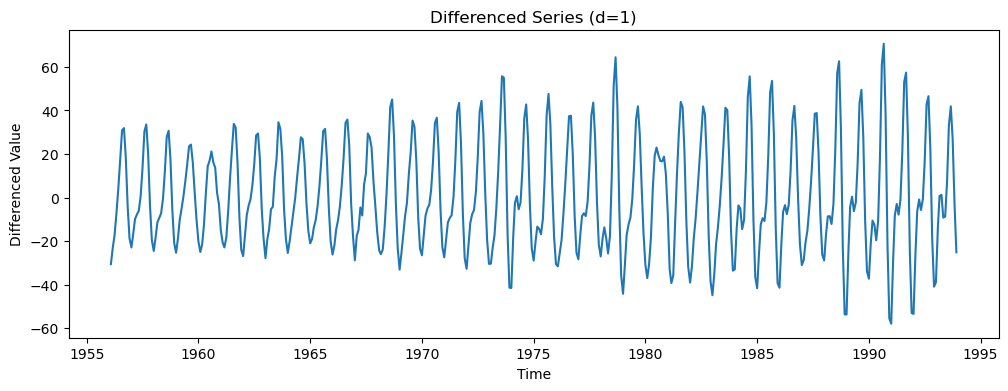

In [6]:
# First difference
train_diff = train.diff().dropna()

# Check stationarity after differencing - use def check stationarity
check_stationarity(train_diff)

# Plot differenced series
plt.figure(figsize=(12, 4))
plt.plot(train_diff)
plt.title('Differenced Series (d=1)')
plt.xlabel('Time')
plt.ylabel('Differenced Value')
plt.show()

## Identify ARIMA parameters p and q  
- p = number of lags 
- d = number of differencing  
- q = order of moving average

We use ACF and PACF plots on the **differenced** data to identify the `p` and `q` parameters:

| Plot | Identifies | How to read |
|------|------------|-------------|
| **ACF** | **q** (MA order) | Count significant lags before cutoff |
| **PACF** | **p** (AR order) | Count significant lags before cutoff |



**How to read the plots**:
- Count significant lags (bars exceeding the blue shaded confidence interval)
- The lag where the plot cuts off suggests the order

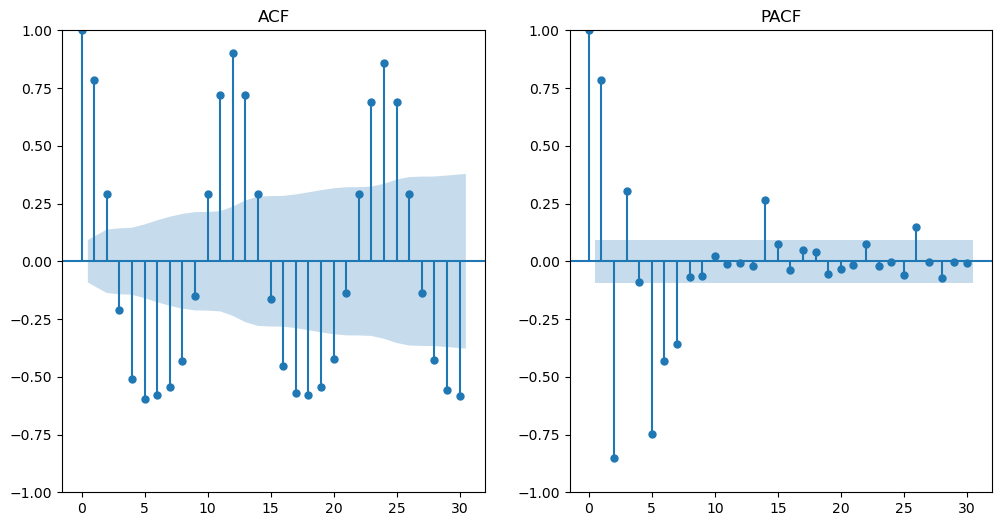

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# q - ACF
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plot_acf(train_diff, lags=30, ax=plt.gca())
plt.title("ACF")

#p - PACF
plt.subplot(1,2,2)
plot_pacf(train_diff, lags=30, ax=plt.gca())
plt.title("PACF")

plt.show()


## Fit ARIMA model and check summary of the model

Based on the ACF/PACF analysis, we select the parameters (p, d, q) and fit the model.

**Important**: Pass the **original** (non-differenced) training data to the ARIMA model. The model handles differencing internally via the `d` parameter.

**model results**  
In statsmodels. the ARIMA model is a special case of the more general 
**SARIMAX** (Seasonal ARIMA with eXogenous variable)

The SARIMAX model has four models under its hat: 
ARIMA
SARIMA
ARIMAX
SARIMAX

In [19]:
# fit ARIMA model
model = ARIMA(train, order=(10,1,1))
model_fit= model.fit()

# Display summary of the model
model_fit.summary()

/opt/anaconda3/envs/CEU/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/CEU/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/CEU/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/CEU/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/CEU/lib/python3.11/site-packages/statsmodels/base/model.py:607: Converg

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  456
Model:                ARIMA(10, 1, 1)   Log Likelihood               -1183.768
Date:                Tue, 27 Jan 2026   AIC                           2391.536
Time:                        10:33:17   BIC                           2440.980
Sample:                    01-01-1956   HQIC                          2411.015
                         - 12-01-1993                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5671      0.351      1.614      0.107      -0.122       1.256
ar.L2          0.3520      0.474      0.742      0.458      -0.578       1.282
ar.L3         -1.2788      0.262     -4.877      0.000      -1.793      -0.765
ar.L4          0.2905      0.264      1.100      0.271      -0.227       0.808
ar.L5          0.2176      0.291      0.747      0.455      -0.354       0.789
ar.L6         -0.4051      0.156     -2.599      0.009      -0.711      -0.100
ar.L7         -0.2084      0.089     -2.353      0.019      -0.382      -0.035
ar.L8         -0.1437      0.115     -1.255      0.210      -0.368       0.081
ar.L9         -0.0816      0.074     -1.109      0.267      -0.226       0.063
ar.L10        -0.0075      0.064     -0.118      0.906      -0.132       0.117
ma.L1          0.8004      0.349      2.295      0.022       0.117       1.484
sigma2        10.3491      0.663     15.607      0.000       9.049      11.649
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                65.65
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                             0.62
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forcasting  and model evaluation

We evaluate the model using common metrics:

| Metric | Description | How to interpret |
|--------|-------------|------------------|
| **MAE** | Mean Absolute Error - average absolute difference | Lower = better. Easy to understand as "average error" |
| **RMSE** | Root Mean Squared Error - penalizes larger errors | Lower = better. If RMSE >> MAE, large outlier errors exist |
| **MAPE** | Mean Absolute Percentage Error - percentage error | <10% = excellent,  10-20% = good,  20-50% = acceptable, >50% = poor |


In [20]:
# Forecasting
# We forecast the same length of test dataset (66)

test_months = len(test)
predictions = model_fit.forecast(steps = test_months)
predictions

1994-01-01    454.310896
1994-02-01    436.977934
1994-03-01    429.791556
1994-04-01    424.193273
1994-05-01    413.586453
                 ...    
2009-12-01    462.423998
2010-01-01    450.913924
2010-02-01    439.502583
2010-03-01    431.958875
2010-04-01    430.199313
Freq: MS, Name: predicted_mean, Length: 196, dtype: float64

In [14]:
# Function to plot results and evaluate model performance
def model_assessment(train, test, predictions, chart_title):
  """Plot train/test/prediction series and print common error metrics.

  Args:
      train (pd.Series): In-sample target used to fit the model.
      test (pd.Series): Holdout target used to evaluate the forecast.
      predictions (pd.Series or np.ndarray): Forecast aligned to `test` index.
      chart_title (str): Short label for the chart (e.g., model name).

  Notes
  -----
  * MAE = mean(|y - ŷ|)
  * RMSE = sqrt(mean((y - ŷ)^2))
  * MAPE = mean(|(y - ŷ)/y|). Use with care when y can be 0.
  """
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = root_mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

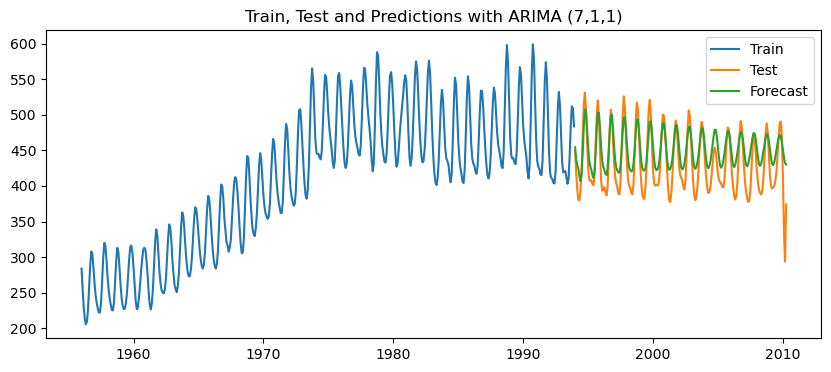

The MAE is 24.52
The RMSE is 29.58
The MAPE is 6.02 %


In [21]:
model_assessment(train, test, predictions, chart_title="ARIMA (7,1,1)")

## Summary

### ARIMA Workflow:

1. **Load and visualize** the time series data
2. **Split** into training (70%) and testing (30%) sets
3. **Check stationarity** using ADF test
4. **Difference** the training data if not stationary
5. **Analyze ACF/PACF** on differenced data to find p and q
6. **Fit ARIMA** model on original training data with (p, d, q)
7. **Forecast** and evaluate the model

### Key Points:

- Only difference the **training data** for ACF/PACF analysis
- Pass **original data** to ARIMA model (it handles differencing via `d`)
- Use **PACF** for AR order (p) and **ACF** for MA order (q)
- Lower **AIC/BIC** indicates better model fit

# SARIMA model
SARIMA extends ARIMA model by adding season component